In [15]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

import zipfile
import io

from tqdm import tqdm
from tqdm import trange, notebook
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings

# 오류 경고 무시하기
warnings.filterwarnings(action='ignore')

In [2]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

In [3]:
# ZIP 파일 경로
zip_file_path = 'kurly.zip'
# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path) as z:
    # ZIP 파일 내에서 'total.csv' 찾기
    with z.open('kurly.csv') as csv_file:
        # CSV 파일을 Pandas DataFrame으로 읽기
        df = pd.read_csv(csv_file)
        
on_items=pd.read_csv('on_items.csv')

In [12]:
# on_items 'ItemCode', 'PriceYear', 'PriceMax' 열만 선택
on_items_filtered = on_items[['ItemCode', 'PriceYear', 'PriceMax']]

# kurly 데이터셋과 on_items_filtered를 'ItemCode'와 'Year' ('PriceYear'에 해당)를 기준으로 결합합니다.
merged_data = pd.merge(df, on_items_filtered, left_on=['ItemCode', 'Year'], right_on=['ItemCode', 'PriceYear'])

# 'maxprice - price'를 계산하여 새로운 열에 추가합니다.
df['MaxPriceDiff'] = (merged_data['PriceMax'] - merged_data['Price'])/merged_data['Price']*100

# 결과를 확인합니다.
df.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName,MaxPriceDiff
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday,5.108632
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday,3.468208
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday,4.985337
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday,5.294118
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday,3.051238


In [33]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 정규화 함수 정의: 각 ItemMiddleName 그룹별로 MaxPriceDiff 정규화
def normalize_max_price_diff(group):
    group['Normalized'] = scaler.fit_transform(group[['Price']])
    return group

# fruits_data를 ItemMiddleName으로 그룹화하고 정규화 함수 적용
data_normalized = df.groupby('ItemMiddleName').apply(normalize_max_price_diff)

# 결과 확인을 위한 출력
print(data_normalized[['ItemMiddleName', 'Price', 'Normalized']].head())

  ItemMiddleName  Price  Normalized
0             과일  17030    0.392364
1             냉동   7680    0.163202
2             축산  12420    0.279159
3             과일   6250    0.121577
4             수산  14450    0.331841


In [34]:
df_plot = data_normalized[['ItemMiddleName', 'Price', 'Normalized']]
df_plot

,ItemMiddleName,Price,Normalized
0,과일,17030,0.392364
1,냉동,7680,0.163202
2,축산,12420,0.279159
3,과일,6250,0.121577
4,수산,14450,0.331841
...,...,...,...
1018706,즉석,19680,0.465691
1018707,과일,18890,0.439086
1018708,채소,13160,0.308236
1018709,채소,17770,0.424709


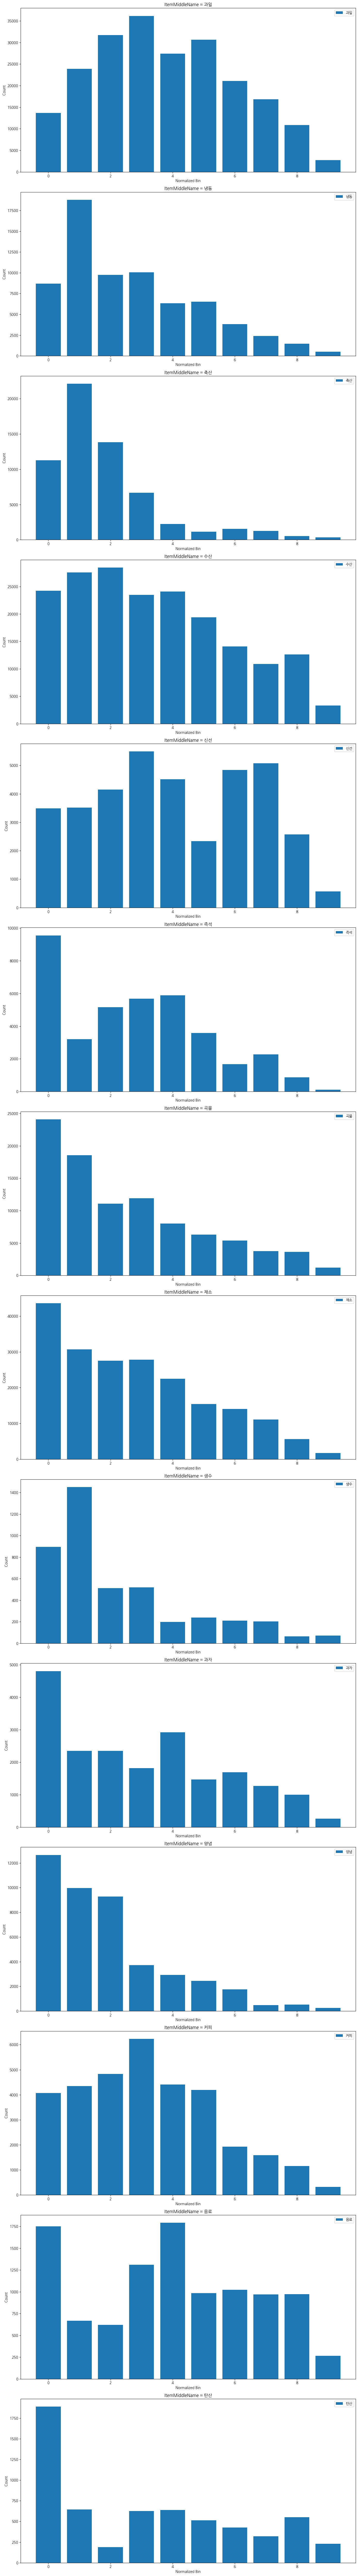

In [36]:
# Normalized 열을 10개의 구간으로 나누기
df_plot['NormalizedBin'] = pd.cut(df_plot['Normalized'], bins=10, labels=False)

# ItemMiddleName과 NormalizedBin 별로 count 계산
grouped_count = df_plot.groupby(['ItemMiddleName', 'NormalizedBin']).size().reset_index(name='Count')

# 각 ItemMiddleName별로 그래프 그리기
import matplotlib.pyplot as plt

# ItemMiddleName 별로 분리하여 그래프 그리기
item_middle_names = df_plot['ItemMiddleName'].unique()

plt.figure(figsize=(14, 100))
for index, name in enumerate(item_middle_names):
    plt.subplot(len(item_middle_names), 1, index + 1)
    subset = grouped_count[grouped_count['ItemMiddleName'] == name]
    plt.bar(subset['NormalizedBin'], subset['Count'], label=name)
    plt.title(f'ItemMiddleName = {name}')
    plt.xlabel('Normalized Bin')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

### 월별 상품 개수

In [57]:
df.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName,MaxPriceDiff,YearMonth,YearMonthStr
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday,5.108632,2021-12,2021-12
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday,3.468208,2021-12,2021-12
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday,4.985337,2021-12,2021-12
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday,5.294118,2021-12,2021-12
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday,3.051238,2021-12,2021-12


In [61]:
df['OrderDT'] = pd.to_datetime(df['OrderDT'])

# 월별 상품 개수를 계산하기 위해, 먼저 각 행의 '년도-월' 정보를 문자열로 변환
df['YearMonthStr'] = df['OrderDT'].dt.strftime('%Y-%m')

# 월별 상품 개수 집계
monthly_product_counts = df.groupby('YearMonthStr')['ItemCode'].nunique().reset_index(name='ProductCount')

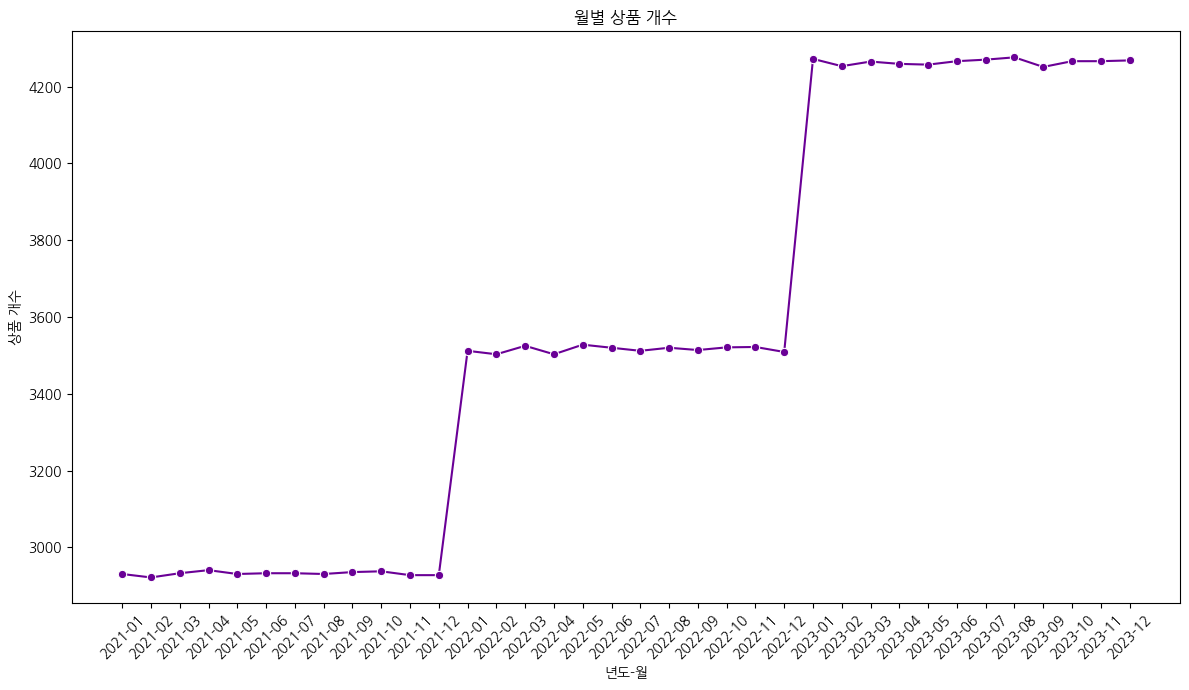

In [63]:
# 월별 상품 개수 집계
monthly_product_counts = df.groupby('YearMonthStr')['ItemCode'].nunique().reset_index(name='ProductCount')

# seaborn의 lineplot 사용하여 월별 상품 개수 시각화
plt.figure(figsize=(12, 7))
sns.lineplot(data=monthly_product_counts, x='YearMonthStr', y='ProductCount', marker='o',color="6A0096")
plt.title('월별 상품 개수')
plt.xlabel('년도-월')
plt.ylabel('상품 개수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

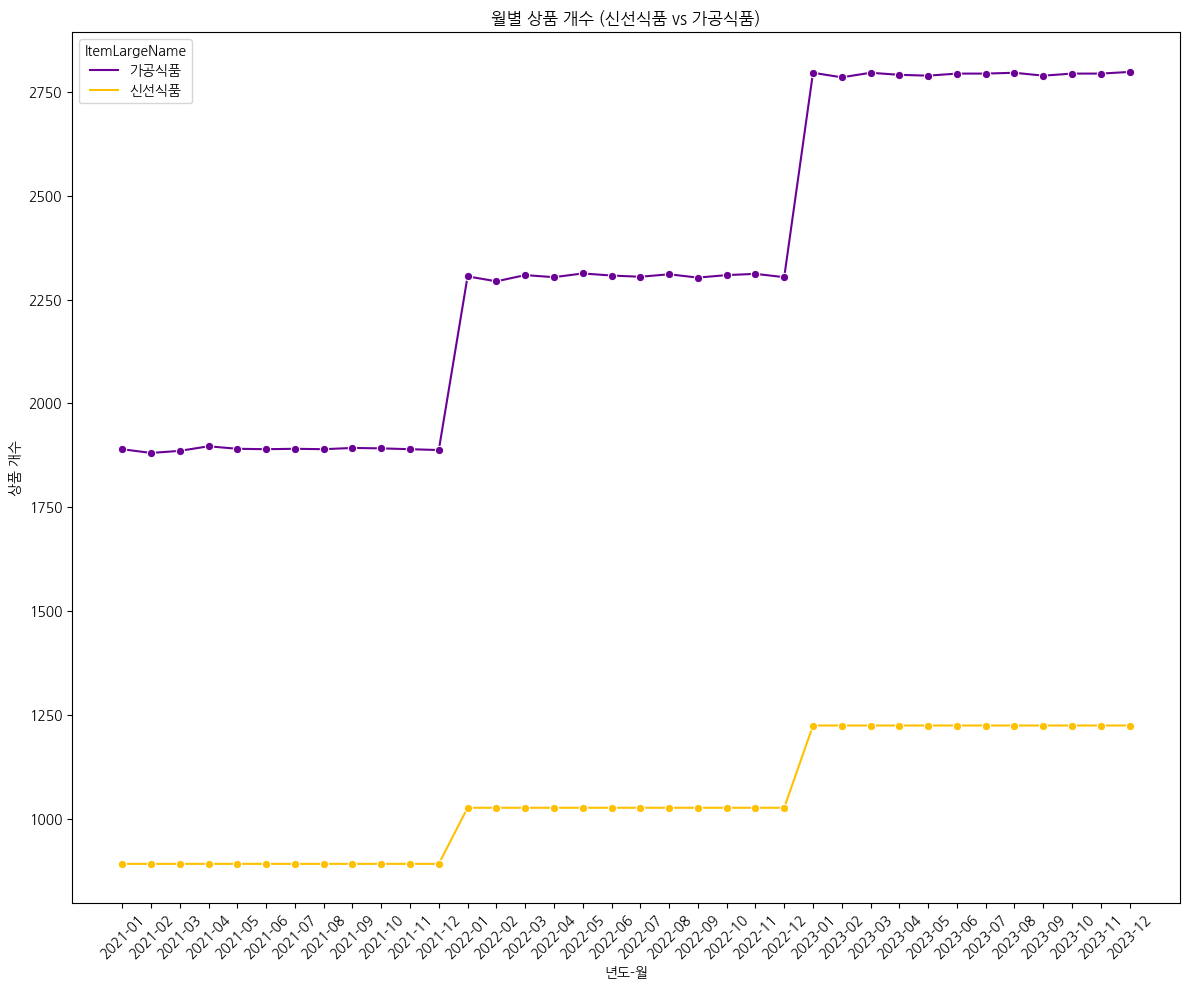

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# 데이터 필터링
filtered_df = df[df['ItemLargeName'].isin(['신선식품', '가공식품'])]

# 데이터 집계
monthly_large_product_counts = filtered_df.groupby(['YearMonthStr', 'ItemLargeName'])['ItemCode'].nunique().reset_index(name='ProductCount')

# 시각화
plt.figure(figsize=(12, 10))
sns.lineplot(data=monthly_large_product_counts, x='YearMonthStr', y='ProductCount', hue='ItemLargeName', marker='o',palette=['#6A0096','#FFC000'])
plt.title('월별 상품 개수 (신선식품 vs 가공식품)')
plt.xlabel('년도-월')
plt.ylabel('상품 개수')
plt.xticks(rotation=45)
plt.legend(title='ItemLargeName')
plt.tight_layout()
plt.show()

### 군집분석

In [5]:
df.columns

Index(['idUser', 'idOrder', 'OrderDT', 'ItemCode', 'Price', 'DeliveryDT',
       'Delay_YN', 'ItemLargeCode', 'ItemLargeName', 'ItemMiddleCode',
       'ItemMiddleName', 'ItemSmallCode', 'ItemSmallName', 'ItemName',
       'Gender', 'Age', 'FamilyCount', 'MemberYN', 'AgeGroup', 'Date', 'Year',
       'Month', 'Day', 'Hour', 'CleanedItemName', 'TimeBetweenOrders',
       'Combined', 'Weekday', 'WeekdayName'],
      dtype='object')

In [ ]:
kurly_df=df.drop(columns=['idUser','idOrder','OrderDT','ItemCode','DeliveryDT','ItemLargeCode','ItemLargeName', 'ItemMiddleCode'
                         ,'ItemMiddleName', 'ItemSmallCode','ItemName','AgeGroup','Age',])

In [8]:
customer_features = df[['Age', 'Price']]

# 데이터 표준화
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)


In [12]:
from tqdm import tqdm

# 적절한 클러스터 수 찾기 (Elbow Method 사용) - tqdm으로 진행 상황 확인
sse = []
for k in tqdm(range(1, 11), desc="Finding optimal number of clusters"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled)
    sse.append(kmeans.inertia_)

Finding optimal number of clusters: 100%|███████| 10/10 [01:09<00:00,  6.95s/it]


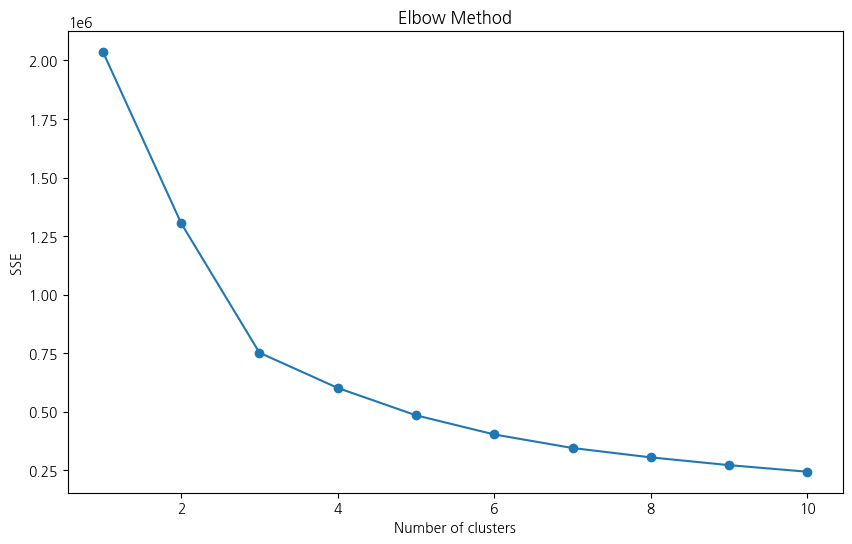

In [13]:
# SSE의 감소량을 그래프로 표현하여 Elbow Point 찾기
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

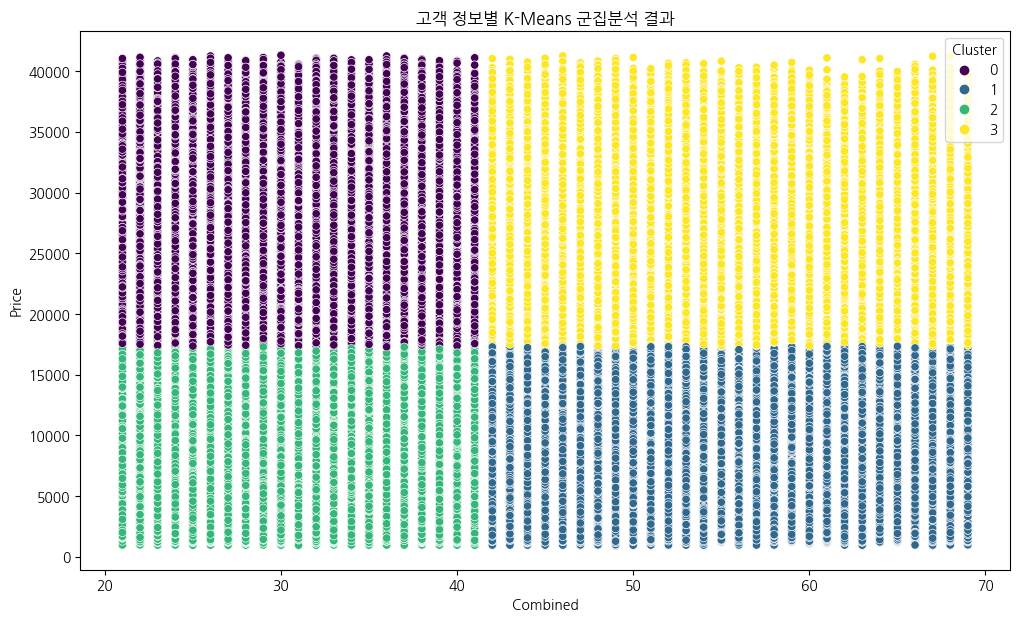

In [86]:
# 위의 그래프를 기반으로 적절한 클러스터 수를 선택하여 KMeans 군집화 수행
# 예: n_clusters = 3으로 결정했다고 가정
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(customer_features_scaled)

# 군집 결과를 DataFrame에 추가
df['Cluster'] = clusters

# 군집 결과 시각화
# 'AgeGroup'과 'Price'를 기준으로 군집 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Age', y='Price', hue='Cluster', data=df, palette='viridis', legend='full')
plt.title('고객 정보별 K-Means 군집분석 결과')
plt.xlabel('Combined')
plt.ylabel('Price')
plt.show()


In [22]:
df.columns

Index(['idUser', 'idOrder', 'OrderDT', 'ItemCode', 'Price', 'DeliveryDT',
       'Delay_YN', 'ItemLargeCode', 'ItemLargeName', 'ItemMiddleCode',
       'ItemMiddleName', 'ItemSmallCode', 'ItemSmallName', 'ItemName',
       'Gender', 'Age', 'FamilyCount', 'MemberYN', 'AgeGroup', 'Date', 'Year',
       'Month', 'Day', 'Hour', 'CleanedItemName', 'TimeBetweenOrders',
       'Combined', 'Weekday', 'WeekdayName', 'Cluster'],
      dtype='object')

In [87]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age','FamilyCount']),
        ('cat', OneHotEncoder(), ['Gender', 'MemberYN'])# 수치형 데이터 표준화
  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

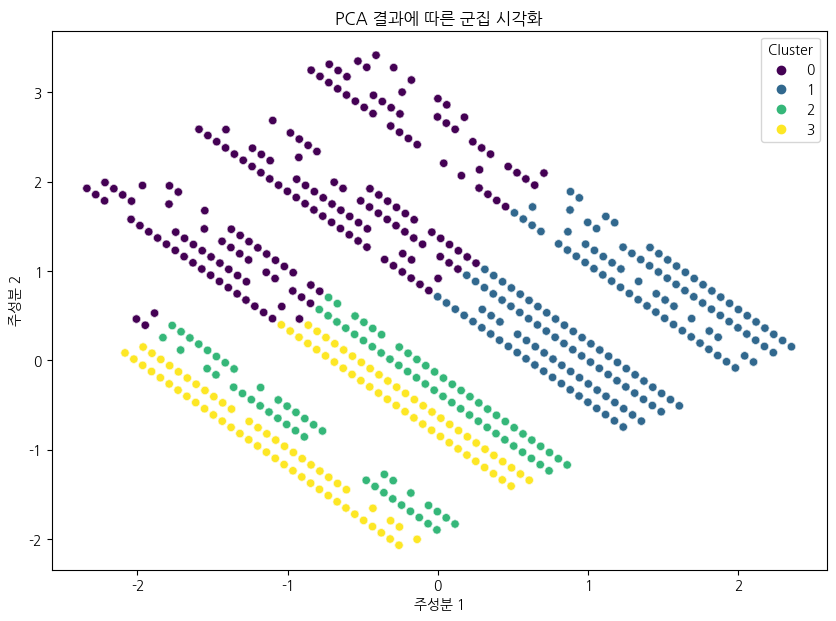

In [88]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [59]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), ['Gender', 'MemberYN'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

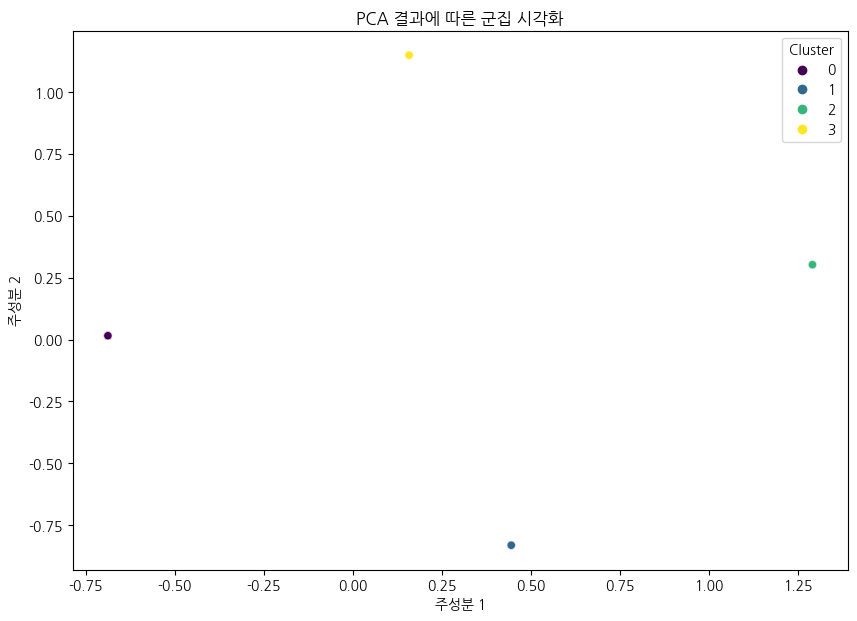

In [60]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [61]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']),  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), ['MemberYN'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

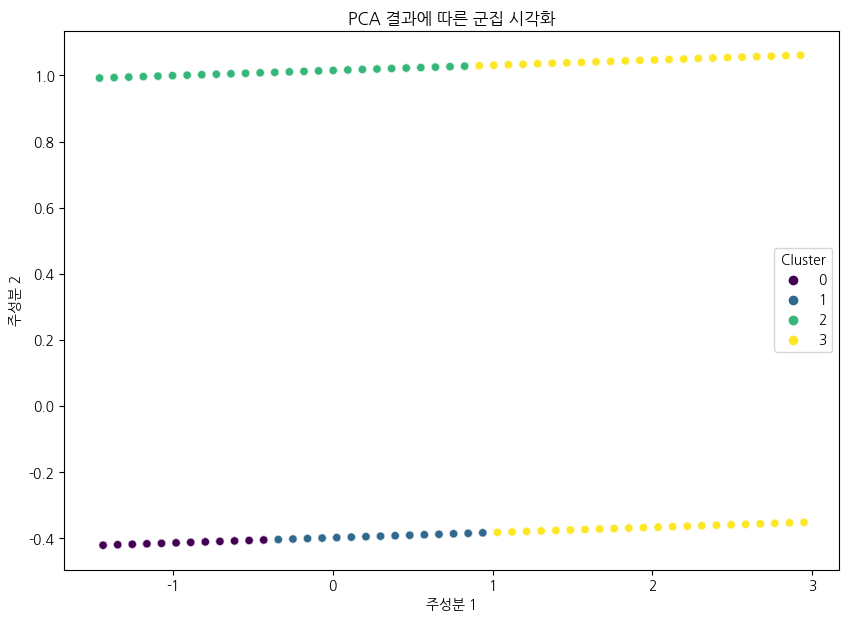

In [62]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [63]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']),  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), ['Gender'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

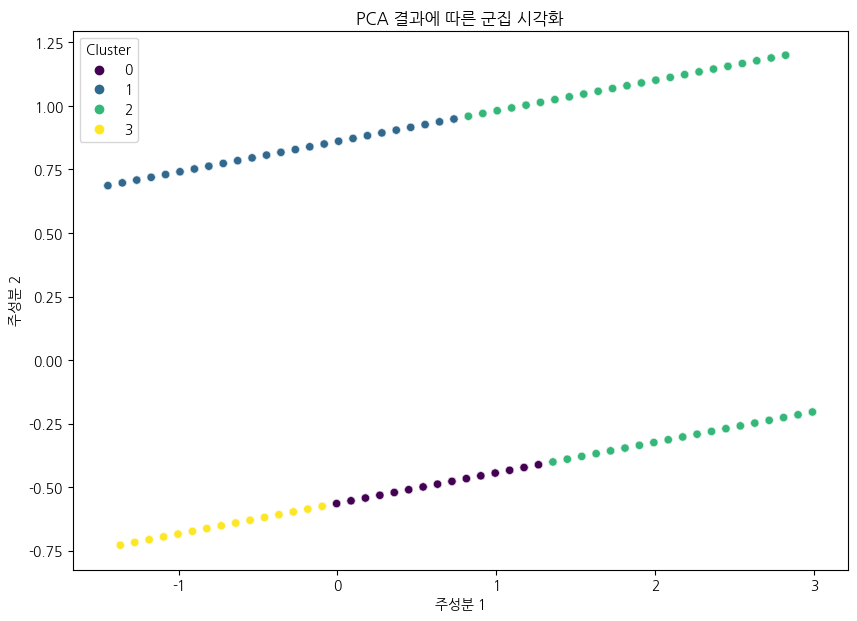

In [64]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [65]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['FamilyCount']),  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), ['Gender'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

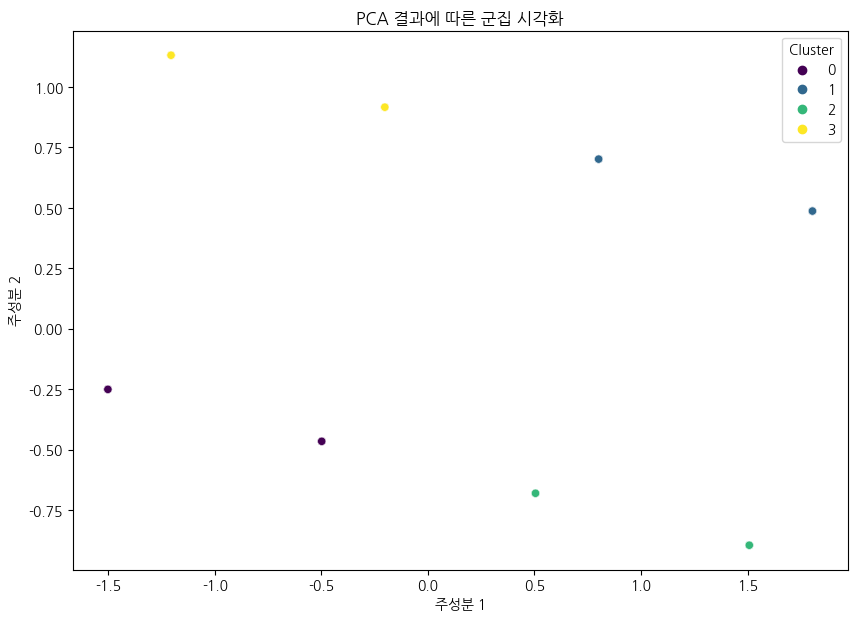

In [66]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [67]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['FamilyCount']),  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), [ 'MemberYN'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

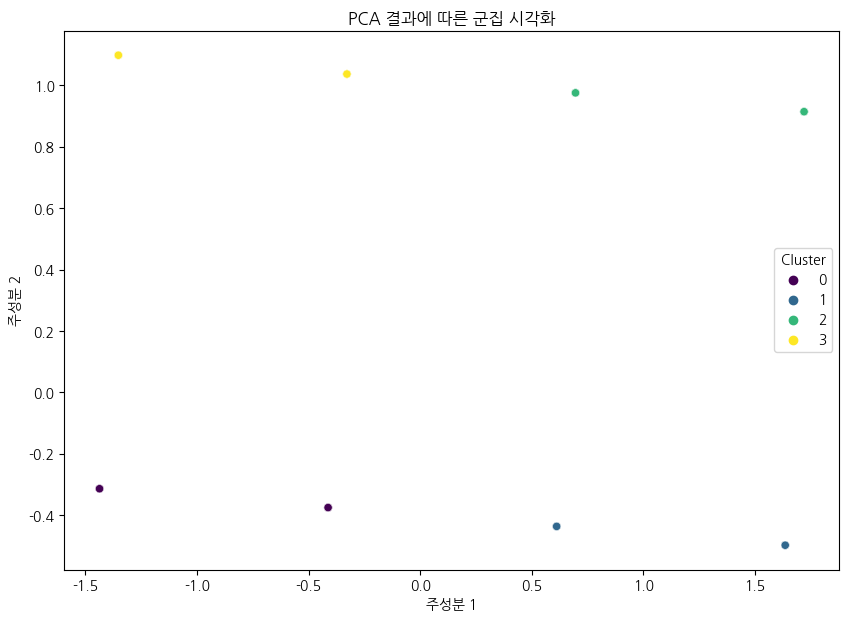

In [68]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [91]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# 데이터 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']),  # 수치형 데이터 표준화
        ('cat', OneHotEncoder(), ['Gender','MemberYN'])  # 범주형 데이터 더미 변수 변환
    ])

# K-Means 모델 파이프라인 구성
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=4, random_state=42))])

# 군집 분석 수행
kmeans_pipeline.fit(df)

# 군집 결과
clusters = kmeans_pipeline.predict(df)
df['Cluster'] = clusters

# 군집 결과 확인
print(df.head())

   idUser            idOrder              OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M15-S0140-1247   7680   
2  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L1-M23-S0580-1047  12420   
3  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M12-S0640-1010   6250   
4  U10001  U10001-O2021-1001  2021-12-03 20:59:27  L4-M17-S0130-1018  14450   

            DeliveryDT  Delay_YN ItemLargeCode ItemLargeName ItemMiddleCode  \
0  2021-12-04 03:26:00         0            L1          가공식품            M12   
1  2021-12-04 03:26:00         0            L1          가공식품            M15   
2  2021-12-04 03:26:00         0            L1          가공식품            M23   
3  2021-12-04 03:26:00         0            L4          신선식품            M12   
4  2021-12-04 03:26:00         0            L4          신선식품            M17   

   ...  Year Month Day Hour                       

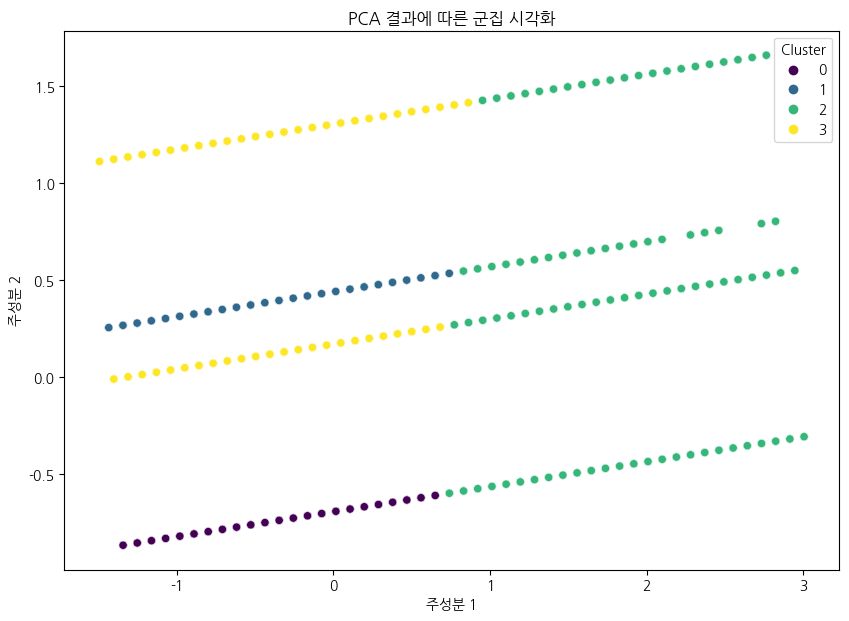

In [92]:
# 군집화 결과를 시각화하기 위해 PCA를 사용하여 고차원 데이터를 2차원으로 축소
from sklearn.decomposition import PCA

# 전처리된 데이터
preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(df)

# PCA 수행 (2차원으로 축소)
pca = PCA(n_components=2)
components = pca.fit_transform(preprocessed_data)

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [85]:
df_3 = df[df['Cluster']==3][['FamilyCount','MemberYN','Cluster']]
print(df_3['FamilyCount'].unique())
print(df_3['MemberYN'].unique())


[3 2]
['N']


### 뭔지 모르겠다.

In [37]:
df_2 = df[df['Cluster']==2][['Combined','Cluster']]
df_2['Combined'].unique()

array(['2030s, 남성', '4060s, 남성'], dtype=object)

In [89]:
# MaxPriceDiffBin 열의 각 값별로 개수 계산
bin_counts = df_plot['MaxPriceDiffBin'].value_counts()
bin_counts

1    517143
2    456021
3     42769
4      2778
Name: MaxPriceDiffBin, dtype: int64

In [79]:
df_plot[(df_plot['MaxPriceDiffBin']=='3')&(df_plot['ItemMiddleName']=='수산')].count()/bin_counts[2]

ItemMiddleName     0.187355
MaxPriceDiff       0.187355
MaxPriceDiffBin    0.187355
dtype: float64

In [80]:
df_plot[(df_plot['MaxPriceDiffBin']=='4')&(df_plot['ItemMiddleName']=='수산')].count()/bin_counts[3]

ItemMiddleName     0.167747
MaxPriceDiff       0.167747
MaxPriceDiffBin    0.167747
dtype: float64

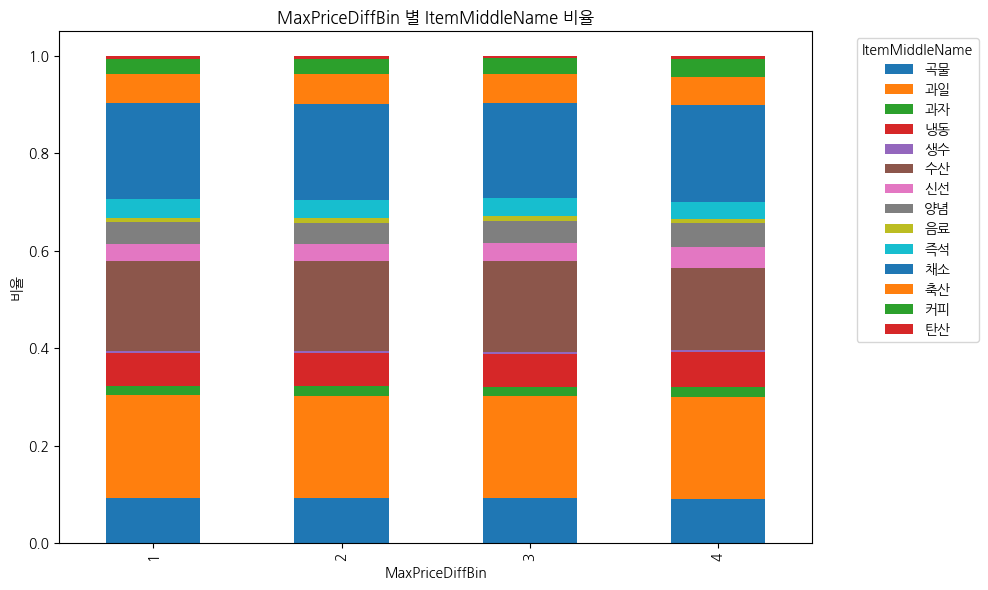

In [71]:
# MaxPriceDiffBin 별로 전체 데이터에서 각 ItemMiddleName이 차지하는 비율을 계산하고 그래프로 그리기

# MaxPriceDiffBin과 ItemMiddleName 별로 데이터를 그룹화하고, 각 그룹의 크기를 계산
grouped = df_plot.groupby(['MaxPriceDiffBin', 'ItemMiddleName']).size().unstack(fill_value=0)

# 각 MaxPriceDiffBin에서의 전체 개수로 나누어 비율 계산
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0)

# 비율을 기반으로 스택 바 차트 그리기
grouped_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('MaxPriceDiffBin 별 ItemMiddleName 비율')
plt.xlabel('MaxPriceDiffBin')
plt.ylabel('비율')
plt.legend(title='ItemMiddleName', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()